Here's my attempt at making a simple CNN to train and make predictions on the MINST digits dataset.  We'll start off by importing the libraries and functions we'll be using

In [1]:
#Imports
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam

Next, we gotta import the data.  Kaggle stores it in the folders below, from which we import it.

In [2]:
#Reads in the training and testing sets.  
df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test =  pd.read_csv("/kaggle/input/digit-recognizer/test.csv") #Won't see this again until later

print(df.shape)
print(test.shape)
print(df.head())

(42000, 785)
(28000, 784)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0   

As seen above, these are datasets of pixels by image, with each row representing a seperate image of 784 pixels (likely 28 high X 28 wide). The training set contains 42000 images, while the testing set contains 28000. This appears to be monohromatic, as there is only one layer. Were they not black and white, we could expect three different sets of values for each pixel, representing red, green, and blue.

The training set has an extra column relating to the actual digit drawn for each image (the labels). Going forward, that is going to be very important information but we need to seperate it out so we only have pixel data in the training set. Below, the labels are sectioned off into their own list, and the corrisponding column is dropped from the training set.  We also get the counts of each different label, which will be helpful to know.

In [3]:
#Makes a list of the actual digits drawn for each image, then get's rid of that column from the training set
labels = df["label"]
X = df.drop('label', axis = 1)
print(labels.value_counts())

print("Baseline Accuracy: " + str(round(labels.value_counts().max()/labels.value_counts().sum(),3)))

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64
Baseline Accuracy: 0.112


Above are the value counts for each label.  As you can see, it's fairly uniformly distributed, although there are some differences between categories.  Having a uniform distribution makes categorical classification a bit easier.  We also now know the base accuracy we need to achieve with the model to do better than just guessing the most common category every time (the number 1 in this case).  If the model does better than that, then it's a fair bet it's actually learnng from the imagery.

Now let's find the range of potential values for each pixel

In [4]:
print(X.values.max())
print(X.values.min())

255
0


Pretty standard configuration: 0 is black, 255 is white.  We should adjust the values so they fall between 0 and 1, which makes it easier for the model to handle later.  We should also reshape and re-type the data to the required format.  Let's wrap it all up in a function.

Note: Keras has built-in ways to do this stuff, but here it is anyway.

In [5]:
#Normalizes values in dataframe to 0-1, and reshapes it to the required dimensions 
def normalizeANDreshape(df, minimum, maximum): 
    diff = maximum - minimum
    zero_min = df - minimum
    adjusted = zero_min/diff
    
    shaped = adjusted.values.reshape(-1,28,28,1) #the width and height of the images, 1 layer deep because it's monochromatic (would be 3 if it contained RGB values)
    
    return shaped

print(np.max(normalizeANDreshape(X, 0, 255)))
print(np.min(normalizeANDreshape(X, 0, 255)))
print(type(normalizeANDreshape(X, 0, 255)))
print(normalizeANDreshape(X, 0, 255).shape)

1.0
0.0
<class 'numpy.ndarray'>
(42000, 28, 28, 1)


As you can see, we now have a function that will get the image data ready for us.

Now we need to process the labels, i.e. get dummy variables, to train the model with.

In [6]:
#Dummy lables in a dataframe
y = pd.get_dummies(labels)
y.head()

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


Now to train this model well (and help avoid overfitting) we need to section off some of the training data into a validation set.  This way the model has some way to evaluate itself independent of the data it's using to train as it trains. 

In [7]:
#Splits into training and validation sets.  Uses 20% of data as validation
X_train, X_val, y_train, y_val = train_test_split(normalizeANDreshape(X, 0, 255), y, test_size = 0.20)

Now this dataset is small enough (~122 MB) to fit into working memory, so we don't need to bother with configuring up directories to process it in chunks.  We will however want to augment it a bit.  

These images are very small.  Also, if you go look at images of what these numbers look like (sorry for not including examples in here), you'll see that all of the numbers are fairly standard: right side up, not mirrored, not too tilted, etc.  Thus, we shouldn't need to do too much to avoid overfitting; we'll just shift things around, rotate slightly, and zoom a bit.

Note: we do not want to augment the testing or the validation sets.

In [8]:
#Augments the data with some rotated, shifted, and zoomed images
augment = ImageDataGenerator(rotation_range = 15,
                                  width_shift_range = 0.35,
                                  height_shift_range = 0.35,
                                  zoom_range = 0.2,
                                  )
augment.fit(X_train)

Now we need to make the model.  As hinted at in the title, it's going to be a simple convoluted neural network (CNN).  Below is a function that will create the framework.  Lot's of ways to do this, and the images are fairly simple and small, so we shouldn't need too complex a network to get good results; below is one possiblity.

In [9]:
#Sets the model architecture
#Won't into how this works heree
def makeCNN(shape):
    
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = (4,4), padding = 'same', activation = 'relu', input_shape = shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))

    model.add(Conv2D(filters = 128, kernel_size = (2,2), padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.25))

    model.add(Dense(10, activation = 'softmax'))

    return model
    
#Displays a summary of the model
model = makeCNN((28, 28, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          3

We now have a model framework with about 182k parameters.  Next, we need to compile it.  We'll try using the 'Adam' optomizer function, which will adapt the learning rate, along with categorical crossentropy for loss (becuase we are looking for categorical classification), and measure accuracy.

In [10]:
#Compiles the model
model.compile(optimizer = Adam(), #Default learning rate is 0.001
             loss = 'categorical_crossentropy',
             metrics = 'accuracy')

All that's left is to train it.  We'll choose 50 epochs and a batch size of 64.  The images are pretty small, so this shouldn't take too long.  Could probably even do K-fold validation in a reasonable time.  

In [11]:
#This isn't likely to take long, so we'll use a large epoch.  Also, fitting things into memory isn't gonna be a problem, so batch size of 64 should be fine
epochs = 50
batch_size = 64

#Trains the model
history = model.fit_generator(augment.flow(X_train,y_train, batch_size=batch_size),  #Retrieves the augmented images from the ImageDataGenerator
                              epochs = epochs, 
                              steps_per_epoch=len(X_train) // batch_size, #So we get the entire training set per epoch
                              validation_data = (X_val,y_val),
                              verbose = 1, 
                              use_multiprocessing = True, #Use multiple CPUs. 
                              workers = 2                 #Kaggle gives you two CPU cores when you use GPU
                             )

Epoch 1/50
525/525 [==============================] - 12s 23ms/step - loss: 1.0487 - accuracy: 0.6402 - val_loss: 0.1610 - val_accuracy: 0.9662
Epoch 2/50
525/525 [==============================] - 11s 21ms/step - loss: 0.3711 - accuracy: 0.8875 - val_loss: 0.0825 - val_accuracy: 0.9777
Epoch 3/50
525/525 [==============================] - 12s 23ms/step - loss: 0.2592 - accuracy: 0.9207 - val_loss: 0.0674 - val_accuracy: 0.9798
Epoch 4/50
525/525 [==============================] - 11s 21ms/step - loss: 0.2237 - accuracy: 0.9335 - val_loss: 0.0584 - val_accuracy: 0.9849
Epoch 5/50
525/525 [==============================] - 13s 25ms/step - loss: 0.1957 - accuracy: 0.9438 - val_loss: 0.0420 - val_accuracy: 0.9886
Epoch 6/50
525/525 [==============================] - 13s 24ms/step - loss: 0.1718 - accuracy: 0.9488 - val_loss: 0.0510 - val_accuracy: 0.9865
Epoch 7/50
525/525 [==============================] - 11s 22ms/step - loss: 0.1633 - accuracy: 0.9523 - val_loss: 0.0394 - val_accuracy:

Its getting high accuracy; definitely some learning going on.  Another interesting facet is that the validation loss is much less than the training loss.  This is because we did not augment the validation dataset, and as a result the validation images are much easier to predict than the augmented training images.  

Let's quickly visualize how it did over time.

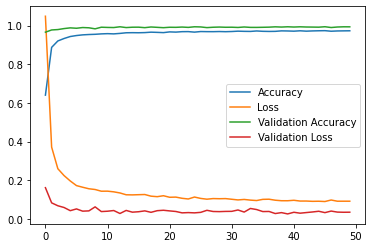

In [12]:
#Plots accuracy and loss across epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['Accuracy', 'Loss', "Validation Accuracy", "Validation Loss"])


As you can see it improved really quickly over a few epochs, then slowed down.  Ends up with a pretty high accuracy.  Let's see if there are any numbers in particular that it has trouble with (at least on the validation set).

In [13]:
#Makes predictions on the validation set 
validation_predictions = model.predict_classes(X_val)

#Sets up a confusion matrix
confusion = confusion_matrix(validation_predictions,y_val.idxmax(axis=1))

print(confusion)

[[816   0   1   0   0   0   1   1   1   2]
 [  0 965   0   0   0   0   0   0   0   0]
 [  1   1 842   1   0   0   0   0   2   0]
 [  0   0   0 861   0   1   1   0   3   0]
 [  0   0   0   0 821   0   1   1   0   2]
 [  0   0   0   0   0 805   2   0   0   2]
 [  0   0   0   0   0   1 771   0   0   0]
 [  0   1   6   1   2   0   0 859   0   6]
 [  0   0   0   0   0   1   0   0 778   2]
 [  0   0   0   0   2   1   0   1   3 831]]


Looks pretty good.  No particular false classification really stands out.  Now, we'll make predictions on the testing data.

In [14]:
#Pre-process the testing data
test = normalizeANDreshape(test, 0, 255)

#Makes class predictions on the test set
predictions = model.predict_classes(test)

print(predictions[0:5])

[2 0 9 0 3]


Quick conclusion:

This is an example of a simple CNN.  These images are pretty basic and don't have too much noise/other things going on aside from the numbers, which makes for a pretty easy classification target.  99% accuracy for this dataset is pretty common, especially with CNNs for which is this pretty much an ideal dataset.  

That said, we still need to make and sumbit the predictions.

In [15]:
#Makes an Id column for the submission
#Should just be int's between 1 and the length of the testing set
Id = []
for i in range(len(test)):
    Id.append(i+1)

    
#Outputs the submission
output = pd.DataFrame({'ImageID': Id, 'Label': predictions})
output.to_csv('predictions.csv', index=False)